In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
vocab = "$abcdefghijklmnopqrstuvwxyz"
vocab_size = len(vocab)
# Create dictionaries for character to index and index to character
ch_to_i = {char: i for i, char in enumerate(vocab)}
i_to_ch = {i: char for i, char in enumerate(vocab)}

In [4]:
import torch.nn.functional as F
# equal_probs = torch.full((vocab_size,), 1.0/vocab_size)
equal_probs = F.softmax(torch.ones(vocab_size), dim=0)
for i in range(5):
    generated = ""
    while True:
        random_int = torch.multinomial(equal_probs, 1).item()
        random_char = i_to_ch[random_int]
        if random_char == "$":
            break
        generated += random_char
    print(f"name {i}: {generated}")

name 0: olprtgmjpmnsmhhsszgdgklbk
name 1: nlibribqhffg
name 2: ebhmehsocsticgnvcyl
name 3: auzawfvenraceiwhxhunikoaefcd
name 4: rgrkzdfo


In [5]:
names = []
with open('../data/p2ch9/names_2022.txt', 'r') as file:
    for line in file:
        name, _, _= line.lower().strip().split(',')
        names.append(name)

Number of names: 31915
Max name length: 15
Min name length: 2
Average name length: 6.0521071596428015


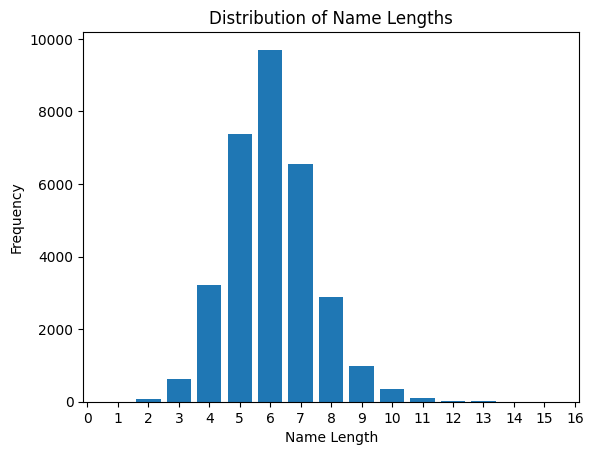

In [6]:
import matplotlib.pyplot as plt

# Calculate the lengths of all names
num_names = len(names)
name_lengths = [len(name) for name in names]
max_name_length = max(name_lengths)
min_name_length = min(name_lengths)
print(f"Number of names: {num_names}")
print(f"Max name length: {max_name_length}")
print(f"Min name length: {min_name_length}")
print(f"Average name length: {sum(name_lengths) / num_names}")

# Create a histogram of name lengths
plt.hist(name_lengths, bins=range(1, 17), align='left', rwidth=0.8)
plt.xlabel('Name Length')
plt.xticks(range(0, 17))
plt.ylabel('Frequency')
plt.title('Distribution of Name Lengths')
plt.show()

In [7]:
# filter out names 10 characters and longer
names = [name for name in names if len(name) < 10]
# Add special character boundary to names
names = ['$' + name + '$' for name in names]

In [8]:
import torch
bigram = torch.zeros((vocab_size, vocab_size))
total = 0
for name in names:
    for ch1, ch2 in zip(name, name[1:]):
        ch1_int = ch_to_i[ch1]
        ch2_int = ch_to_i[ch2]
        bigram[ch1_int][ch2_int] += 1
        total += 1
bigram /= total

In [9]:
for i in range(5):
    generated = "$"
    while True:
        bigram_probs = bigram[ch_to_i[generated[-1]]]
        sampled_char = i_to_ch[
            torch.multinomial(bigram_probs, 1).item()
        ]
        if sampled_char == "$":
            break
        generated += sampled_char
    print(f"name {i}: {generated[1:]}")

name 0: doh
name 1: sma
name 2: asss
name 3: ditahendwstan
name 4: mya


In [10]:
example_name = "$ada$"
# Define encode and decode functions
encode = lambda word: torch.tensor([ch_to_i[c] for c in word])
decode = lambda tensor_i: ''.join(i_to_ch[i.item()] for i in tensor_i)
print(encode(example_name))
print(decode(encode(example_name)))

name_indices = [encode(name) for name in names]
target_indices = [name_index[1:] for name_index in name_indices]

tensor([0, 1, 4, 1, 0])
$ada$


In [11]:
from torch.nn.utils.rnn import pad_sequence
X = pad_sequence(name_indices, batch_first=True, padding_value=0)
# trick to pad Y with a tensor for size 11, then remove the last row
max_name_length = max(len(name) for name in names)
target_indices.append(torch.empty((max_name_length), dtype=torch.long))
Y = pad_sequence(target_indices, batch_first=True, padding_value=-1)[:-1]
print(X[0])
print(Y[0])

tensor([ 0, 15, 12,  9, 22,  9,  1,  0,  0,  0,  0])
tensor([15, 12,  9, 22,  9,  1,  0, -1, -1, -1, -1])


In [12]:
def get_batch(batch_size=64):
    random_idx = torch.randint(0, X.size(0), (batch_size,))
    inputs = X[random_idx]
    labels = Y[random_idx]
    return inputs, labels
inputs, labels = get_batch(3)
print(inputs)
print(labels)

tensor([[ 0, 10,  1,  9,  1,  8,  0,  0,  0,  0,  0],
        [ 0,  5,  2, 18,  9, 13,  1,  0,  0,  0,  0],
        [ 0,  1, 14,  1, 12,  9, 19, 19,  5,  0,  0]])
tensor([[10,  1,  9,  1,  8,  0, -1, -1, -1, -1, -1],
        [ 5,  2, 18,  9, 13,  1,  0, -1, -1, -1, -1],
        [ 1, 14,  1, 12,  9, 19, 19,  5,  0, -1, -1]])


In [13]:
embedding_dim = 3
embedding = nn.Embedding(vocab_size, embedding_dim)
example_input = torch.tensor([1, 1, 0, 2])
input_embd = embedding(example_input)
print(input_embd.shape)
input_embd

torch.Size([4, 3])


tensor([[ 0.4796, -0.2138,  0.0972],
        [ 0.4796, -0.2138,  0.0972],
        [ 0.3381,  0.2404, -1.9988],
        [ 1.5868,  1.1507,  0.7782]], grad_fn=<EmbeddingBackward0>)

In [14]:
example_input = torch.tensor([1, 1, 0, 2])
seq_len = example_input.shape[0]
sequence_embeddings = torch.zeros(seq_len, seq_len * embedding_dim)
print(f"Example: {example_input}")
# Iterate over each position in the sequence
for i in range(seq_len):
    # Create a subsequence of the input sequence up to the i-th element right-padded with zeros
    subsequence = torch.zeros(seq_len, dtype=torch.int)
    prefix = example_input[:i+1]
    subsequence[:i+1] = prefix
    print(f"{subsequence=}")
    # Apply the embedding layer
    emb = embedding(subsequence)
    # Flatten the embeddings and store them in sequence_embeddings
    sequence_embeddings[i, :] = emb.view(-1)
print(sequence_embeddings.shape)

Example: tensor([1, 1, 0, 2])
subsequence=tensor([1, 0, 0, 0], dtype=torch.int32)
subsequence=tensor([1, 1, 0, 0], dtype=torch.int32)
subsequence=tensor([1, 1, 0, 0], dtype=torch.int32)
subsequence=tensor([1, 1, 0, 2], dtype=torch.int32)
torch.Size([4, 12])


In [15]:
class SequenceMLP(nn.Module):
    def __init__(self, vocab_size, max_sequence_length, embedding_dim, hidden_dim=32):
        super().__init__()
        self.vocab_size = vocab_size
        self.max_sequence_length = max_sequence_length
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim * max_sequence_length, hidden_dim)
        self.relu = nn.ReLU()
        self.out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        batch_size, seq_len = x.shape
        sequence_embeddings = torch.zeros(batch_size, seq_len, self.max_sequence_length * self.embedding_dim)
        for i in range(seq_len):  # <1>
            subsequence = torch.zeros(batch_size, self.max_sequence_length, dtype=torch.int)
            prefix = x[:, :i+1]
            subsequence[:, :i+1] = prefix
            emb = self.embedding(subsequence)
            sequence_embeddings[:, i, :] = emb.view(batch_size, -1)  # <2>
        x = self.linear(sequence_embeddings)  # <3>
        x = self.relu(x)
        x = self.out(x)
        return x

embedding_dim = 3
max_sequence_length = X.shape[1]
model = SequenceMLP(vocab_size, max_sequence_length, embedding_dim)

In [16]:
import torch.optim as optim

def train(model, optimizer, num_steps=10_001, loss_report_interval=1_000):
    losses = []
    for i in range(1, num_steps):
        inputs, labels = get_batch()
        optimizer.zero_grad()
        logits = model(inputs)
        loss = F.cross_entropy(logits.view(-1, logits.shape[-1]), labels.view(-1), ignore_index=-1)
        losses.append(loss.item())
        if i % loss_report_interval == 0:
            print(f'Average loss at step {i}: {sum(losses[-loss_report_interval:]) / loss_report_interval:.4f}')
        loss.backward()
        optimizer.step()

optimizer = optim.SGD(model.parameters(), lr=0.1)

In [19]:
train(model, optimizer)

Average loss at step 1000: 2.2941
Average loss at step 2000: 2.2885
Average loss at step 3000: 2.2868
Average loss at step 4000: 2.2888
Average loss at step 5000: 2.2830
Average loss at step 6000: 2.2800
Average loss at step 7000: 2.2795
Average loss at step 8000: 2.2763
Average loss at step 9000: 2.2761
Average loss at step 10000: 2.2742


In [20]:
def generate_samples(model, num_samples=1, max_len=max_name_length):
    sequences = torch.zeros((num_samples, 1)).int()
    for _ in range(max_len):
        logits = model(sequences)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        sequences = torch.cat((sequences, idx_next), dim=1)

    for sequence in sequences:
        indices = torch.where(sequence == 0)[0]
        end = indices[1] if len(indices) > 1 else max_len
        sequence = sequence[1:end]
        print(decode(sequence))

generate_samples(model, num_samples=10)

nhelusy
chovan
jiyla
geryy
avia
taryya
sakri
wain
kex
avraini


In [38]:
import plotly.graph_objects as go
# Assume embeddings is your (28, 3) tensor
embeddings = model.embedding.weight.detach()
# Create a list of labels
labels = ['$', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',
           'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '*']
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=embeddings[:, 0], 
    y=embeddings[:, 1], 
    z=embeddings[:, 2], 
    mode='markers+text',
    text=labels,  # add labels
    textfont=dict(size=12, color="white"),
    marker=dict(size=8),
    textposition='middle center',  # position the labels
    name="characters"
)])
# Add x, y, and z axes as lines
fig.add_trace(go.Scatter3d(x=[-2, 2], y=[0, 0], z=[0, 0], mode='lines', 
                           line=dict(color='black', dash='solid', width=4), name='x-axis'))
fig.add_trace(go.Scatter3d(x=[0, 0], y=[-3, 2], z=[0, 0], mode='lines', 
                           line=dict(color='black', dash='dashdot', width=4), name='y-axis'))
fig.add_trace(go.Scatter3d(x=[0, 0], y=[0, 0], z=[-2, 2], mode='lines', 
                           line=dict(color='black', dash='longdash', width=4), name='z-axis'))
fig.update_layout(
    autosize=False,
    width=800,
    height=700,
    legend=dict(
        orientation="v",
        xanchor="center",
        yanchor="bottom",
        x=.9,
        y=.5,
        font_size=12,
        bordercolor="black",
        borderwidth=1,
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)
# Show the plot
fig.show()